In [1]:
import warnings
warnings.filterwarnings('ignore')


In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from math import sqrt

def analyze_prepared_data(df, title):
    # Specify features and target based on the prepared DataFrame columns
    features = [col for col in df.columns if col != 'Actual Lead Time']
    target = 'Actual Lead Time'
    
    # Initialize lists to store metrics
    min_errors = []
    max_errors = []
    average_errors = []
    median_errors = []
    rmses = []
    r2_scores = []

    # Number of runs
    n_runs = 10

    for _ in range(n_runs):
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=None)
        
        # Define and train the model
        model = RandomForestRegressor(random_state=None)  
        model.fit(X_train, y_train.values.ravel())
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate errors
        errors = np.abs(y_test.values.ravel() - y_pred)
        
        # Collect metrics
        min_errors.append(np.min(errors))
        max_errors.append(np.max(errors))
        average_errors.append(np.mean(errors))
        median_errors.append(np.median(errors))
        rmses.append(sqrt(mean_squared_error(y_test, y_pred)))
        r2_scores.append(r2_score(y_test, y_pred))

    '''
    # Prepare data for plotting
    metrics = [ min_errors,max_errors,average_errors, median_errors, rmses, r2_scores]
    metric_names = ['Min Error','Max Error', 'Average Error', 'Median Error', 'RMSE', 'R-squared']

    # Plotting
    fig, axs = plt.subplots(nrows=1, ncols=len(metric_names), figsize=(20, 6), sharey=False)
    for i, metric in enumerate(metrics):
        axs[i].boxplot(metric)
        axs[i].set_title(metric_names[i])

    plt.tight_layout()
    plt.suptitle(title+': Performance Metrics Across 10 Runs', fontsize=16, y=1.02)  # Add suptitle
    plt.show()
    '''
    metrics = {
        'Min Error': min_errors,
        'Max Error': max_errors,
        'Average Error': average_errors,
        'Median Error': median_errors,
        'RMSE': rmses,
        'R-squared': r2_scores
    }

    # Calculate and display summary statistics
    summary_stats = {}
    for metric_name, values in metrics.items():
        summary_stats[metric_name] = {
            'Mean': np.mean(values),
            'Std Dev': np.std(values),
            'Min': np.min(values),
            '50%': np.median(values),
            'Max': np.max(values)
        }

    summary_df = pd.DataFrame(summary_stats).T
    print(summary_df)




    # Identify and plot effects of the top 5 most important features
    top_indices = np.argsort(model.feature_importances_)[-5:]
    top_features = [features[i] for i in top_indices]

    top_importances = model.feature_importances_[top_indices]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.barh(top_features, top_importances, color='skyblue')
    plt.xlabel('Feature Importance', fontsize=18)  # Increase font size of x-axis label
    plt.ylabel('Features', fontsize=18)            # Increase font size of y-axis label
    plt.title(title, fontsize=18)                  # Increase font size of title
    plt.xticks(fontsize=18)                        # Increase font size of x-axis tick labels
    plt.yticks(fontsize=18)                        # Increase font size of y-axis tick labels
    plt.show()

    

In [3]:
import pandas as pd

def df_date_filter(df, start, end):
    """
    Filters the provided DataFrame for entries between the specified start and end dates.

    Parameters:
        df (DataFrame): The DataFrame to filter.
        start (str or pd.Timestamp): The start date for the filter.
        end (str or pd.Timestamp): The end date for the filter.

    Returns:
        DataFrame: A filtered DataFrame containing only the entries within the specified date range.
    """

    # Create the mask for the date range
    mask = (df['Order Entry Date'] >= start) & (df['Order Entry Date'] <= end)
    filtered_df = df.loc[mask]
    categories = ['Country', 'Transportation Mode', 'Order Type', 'Fulfillment Method', 'Product Category', 
            'Vendor Incoterm', 'Reason Code', 'Item Tracer Category','Framework Contract']
    numeric=['Manufacture','Pick Up','Quality Assurance','Illustrative Price',
         'RO Validation','Sourcing and Planning','USAID Approval','Process PO/DO','Reason Code Duration']
    features=categories+numeric
    target = ['Actual Lead Time']
    
    df_train = filtered_df[features+target]
    df_train.dropna(inplace=True)

    '''
    # Calculate the IQR bounds for each numeric column
    bounds = {}
    for column in numeric:
        Q1 = df_train[column].quantile(0.25)
        Q3 = df_train[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        bounds[column] = (lower_bound, upper_bound)
    
    # Apply the IQR filters to the DataFrame
    for column, (lower_bound, upper_bound) in bounds.items():
        df_train = df_train[(df_train[column] >= lower_bound) & (df_train[column] <= upper_bound)]
    '''
    '''
    Q1 = df_train['Actual Lead Time'].quantile(0.25)
    Q3 = df_train['Actual Lead Time'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_train = df_train[(df_train['Actual Lead Time'] >= lower_bound) & (df_train['Actual Lead Time'] <= upper_bound)]
    '''
    return df_train




In [4]:
import pandas as pd
#Read from file
df=pd.read_csv('USAID_Health_Comodity_Delivery.csv')

numeric_cols = df.select_dtypes(include=['number']).columns

# Replace negative values in numeric columns with NaN
df[numeric_cols] = df[numeric_cols].applymap(lambda x: x if x >= 0 else None)


df['Latest Actual Delivery Date'] = pd.to_datetime(df['Latest Actual Delivery Date'])
df['Order Entry Date'] = pd.to_datetime(df['Order Entry Date'])

# Create the new column
df['Actual Lead Time'] = df['Latest Actual Delivery Date'] - df['Order Entry Date']
df['Actual Lead Time'] = df['Actual Lead Time'].dt.days

#Modify the reason code
df['Reason Code'] = df['Reason Code'].str.slice(0, 2)

categories = ['Country', 'Transportation Mode', 'Order Type', 'Fulfillment Method', 'Product Category', 
        'Vendor Incoterm', 'Reason Code', 'Item Tracer Category','Framework Contract']
numeric=['Manufacture','Pick Up','Quality Assurance','Illustrative Price',
        'RO Validation','Sourcing and Planning','USAID Approval','Process PO/DO','Reason Code Duration']




# Label econding for the categorical data in df
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in categories:
    df[i] = le.fit_transform(df[i])

#For every nan value use the average of the column group by 'Product Category'
for i in numeric:
    df[i] = df[i].fillna(df.groupby('Product Category')[i].transform('mean'))



16048


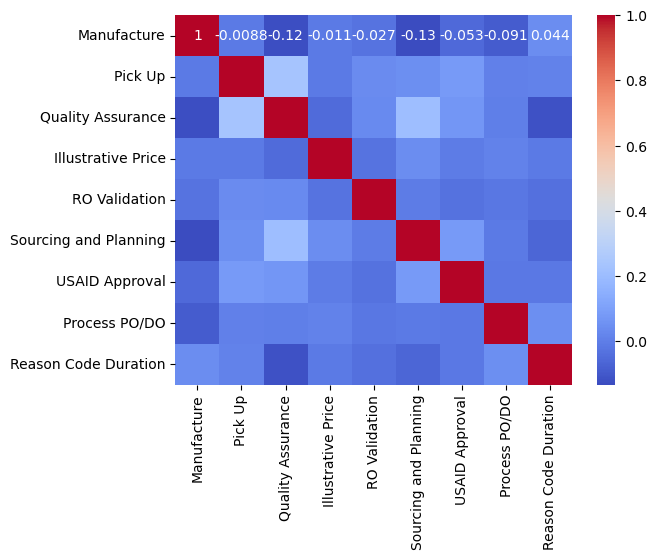

Summary Statistics:
         Manufacture       Pick Up  Quality Assurance  Illustrative Price  \
count  16048.000000  16048.000000       16048.000000        16048.000000   
mean      82.808072     46.189876          26.600276          259.011864   
std       60.443700     29.282295          26.804955         2500.325074   
min        0.000000      0.000000           0.000000            0.010000   
25%       45.000000     40.000000          13.000000            6.540000   
50%       79.696613     40.167466          13.000000           18.380000   
75%       98.071139     48.598383          35.000000           90.052500   
max      723.000000    548.000000         581.000000        77290.000000   

       RO Validation  Sourcing and Planning  USAID Approval  Process PO/DO  \
count   16048.000000           16048.000000    16048.000000   16048.000000   
mean       24.491475              70.843089        4.249538      50.935819   
std        31.732346              50.784029       13.727549 

In [5]:
#Some analysis for reliability
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import researchpy as rp

# Load dataset
data = df_date_filter(df, df['Order Entry Date'].min(), df['Order Entry Date'].max())
data=data[numeric]
print(len(data))
# Summary Statistics
summary_stats = data.describe()

# Correlation Matrix
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

# Variance Inflation Factor (VIF)
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["Variable"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

# Assuming 'data' is preprocessed and only includes numerical columns
vif = calculate_vif(data.select_dtypes(include=[np.number]))


# Output results
print("Summary Statistics:\n", summary_stats)
print("VIF:\n", vif)


In [6]:
# Filter dataframes
whole_df = df_date_filter(df, df['Order Entry Date'].min(), df['Order Entry Date'].max())
after_covid_df = df_date_filter(df, '2020-01-01', df['Order Entry Date'].max())
before_covid_df = df_date_filter(df, df['Order Entry Date'].min(), '2020-01-01')
peak_df = df_date_filter(df, '2020-01-01', '2022-03-22')

# Using df_date_filter to get before and after peak periods separately
before_peak_df = df_date_filter(df, df['Order Entry Date'].min(), '2019-12-31')
after_peak_df = df_date_filter(df, '2022-03-23', df['Order Entry Date'].max())

# Concatenating both DataFrames to create a non-peak DataFrame
non_peak_df = pd.concat([before_peak_df, after_peak_df], ignore_index=True)

# Optionally, you can print the number of records in each DataFrame to validate the splits
print("Whole period records:", len(whole_df))
print("After COVID records:", len(after_covid_df))
print("Before COVID records:", len(before_covid_df))
print("Peak period records:", len(peak_df))
print("Non-peak period records:", len(non_peak_df))


Whole period records: 16048
After COVID records: 6934
Before COVID records: 9114
Peak period records: 5655
Non-peak period records: 10393


                     Mean     Std Dev         Min         50%         Max
Min Error        0.000000    0.000000    0.000000    0.000000    0.000000
Max Error      464.314000  110.311781  362.020000  407.715833  630.270000
Average Error   21.075947    0.482315   20.353922   20.943355   21.823015
Median Error     7.369039    0.229712    6.920417    7.358750    7.765250
RMSE            42.152660    1.416370   39.915056   42.312299   44.411754
R-squared        0.901200    0.006172    0.889994    0.901108    0.912496


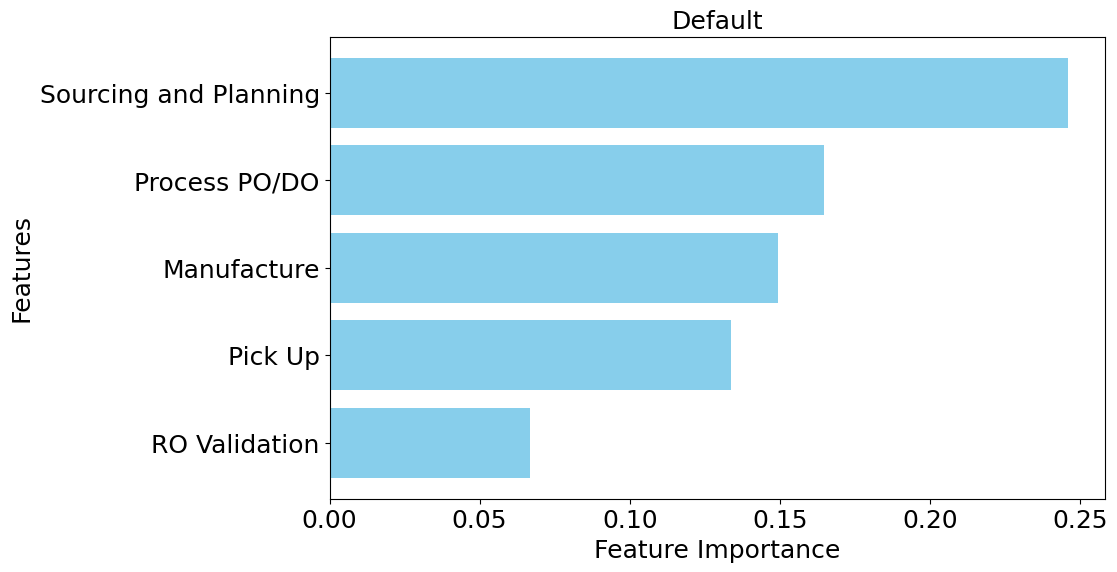

                     Mean    Std Dev         Min         50%         Max
Min Error        0.000000   0.000000    0.000000    0.000000    0.000000
Max Error      352.656852  45.528026  293.520000  366.495000  405.716667
Average Error   17.018076   0.500278   16.339799   17.002397   17.849469
Median Error     5.307654   0.388403    4.800000    5.365000    5.990000
RMSE            35.190676   1.876886   32.374116   34.817471   38.344268
R-squared        0.921289   0.008317    0.907934    0.921682    0.934575


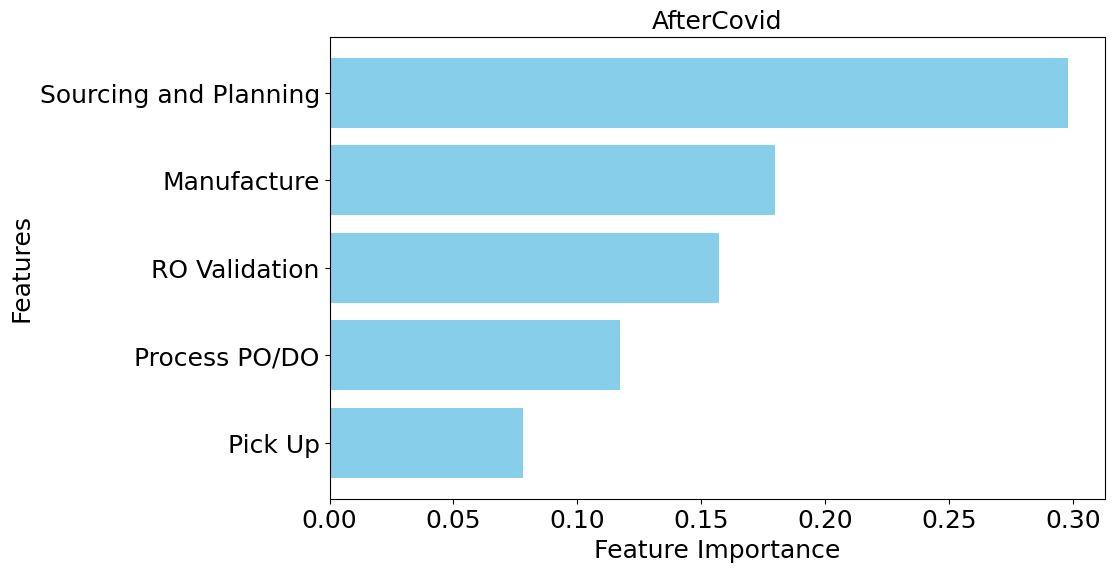

                     Mean     Std Dev         Min         50%         Max
Min Error        0.000000    0.000000    0.000000    0.000000    0.000000
Max Error      440.079818  114.282278  285.120000  418.913500  652.860000
Average Error   24.476371    0.699778   23.626696   24.485146   25.769621
Median Error     9.264825    0.523497    8.605000    9.140000   10.387500
RMSE            46.986873    1.983693   43.517404   47.026468   49.803083
R-squared        0.886578    0.009011    0.867546    0.888400    0.900446


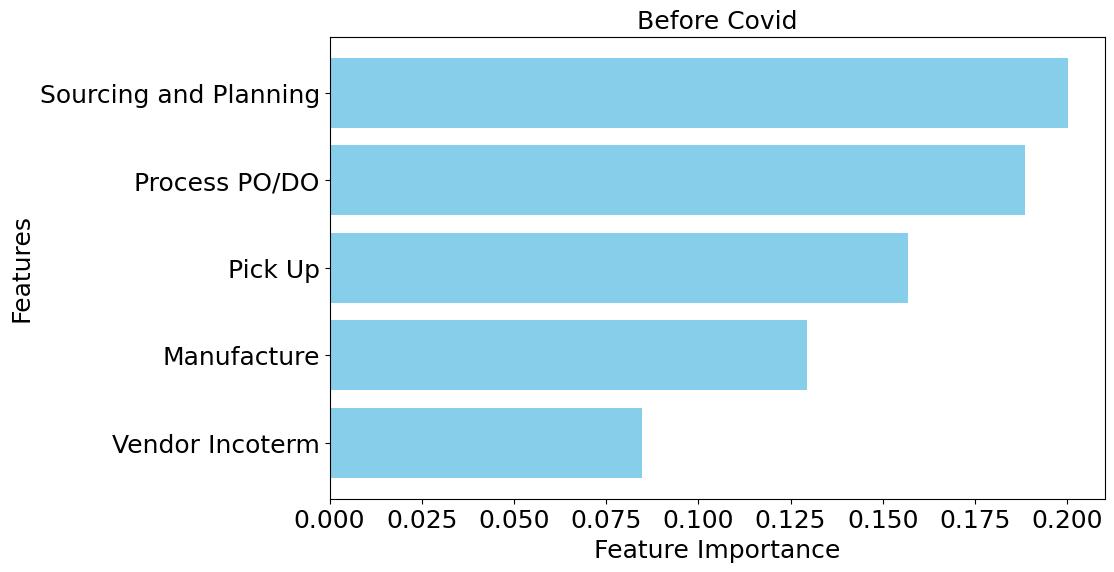

                     Mean    Std Dev         Min         50%         Max
Min Error        0.000000   0.000000    0.000000    0.000000    0.000000
Max Error      347.398500  51.918250  255.960000  349.070000  420.255000
Average Error   17.950327   0.702485   16.996303   17.917005   19.084224
Median Error     5.920157   0.366909    5.250000    5.918000    6.462000
RMSE            36.716059   2.226583   32.200916   37.523742   40.383430
R-squared        0.920221   0.008786    0.905290    0.919006    0.935337


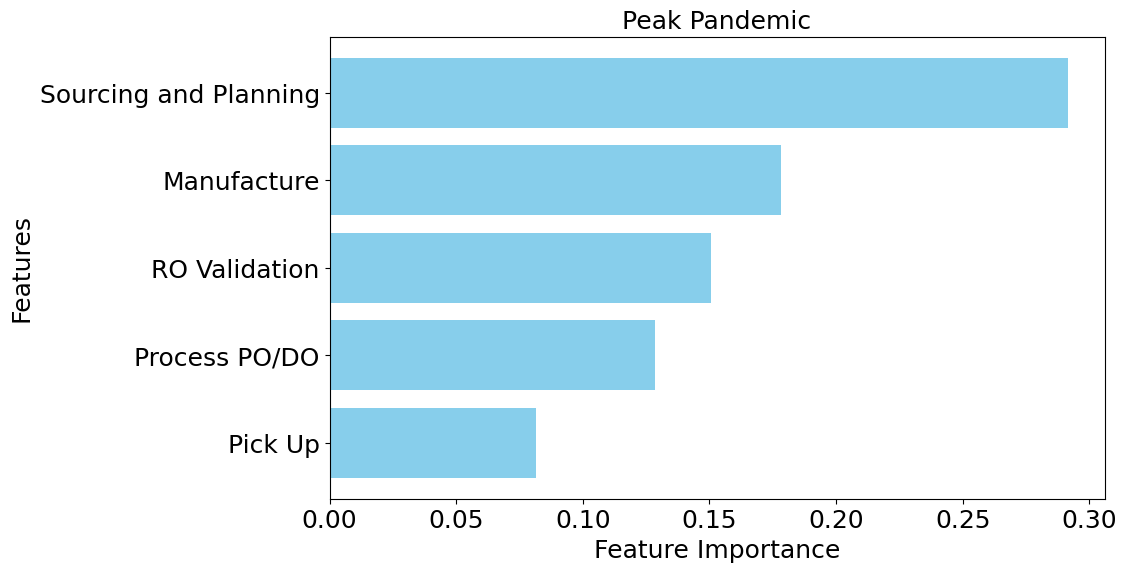

                     Mean     Std Dev         Min         50%         Max
Min Error        0.000000    0.000000    0.000000    0.000000    0.000000
Max Error      491.018560  107.878659  322.732299  477.085744  655.220000
Average Error   23.217487    0.872260   21.923794   23.147831   25.290865
Median Error     8.446858    0.540589    7.440000    8.616472    9.175631
RMSE            45.953584    2.457923   41.692671   46.098566   50.554981
R-squared        0.883994    0.012266    0.860092    0.885800    0.903781


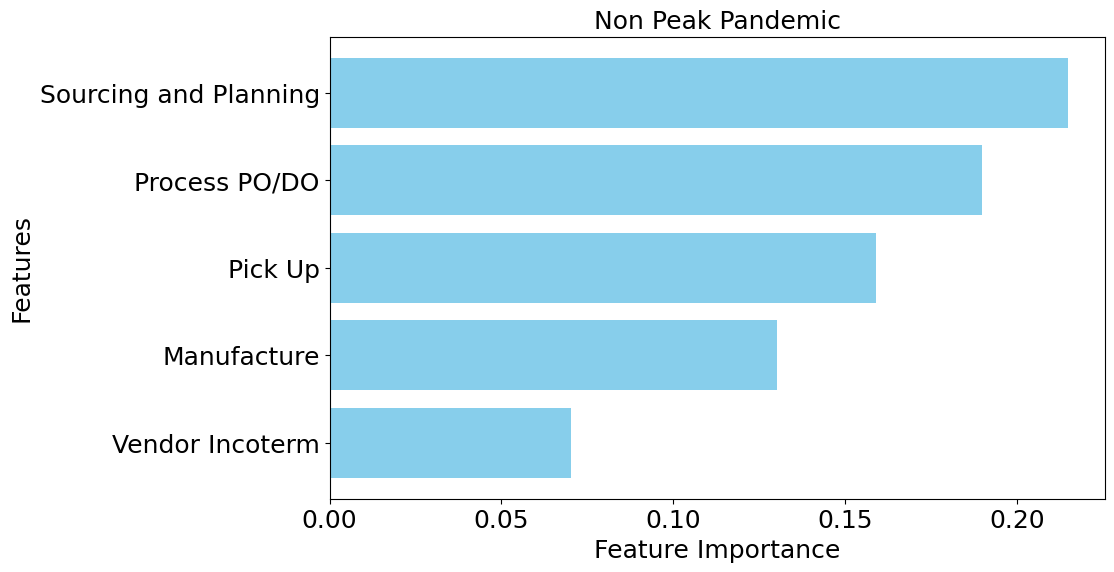

In [7]:
analyze_prepared_data(whole_df,'Default')
analyze_prepared_data(after_covid_df,'AfterCovid')
analyze_prepared_data(before_covid_df,'Before Covid')
analyze_prepared_data(peak_df,'Peak Pandemic')
analyze_prepared_data(non_peak_df,'Non Peak Pandemic')